In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import math
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Web Scraping

In [3]:
#loading in a csv I made that that has links to all the minor league teams in existence 
all_csvs_2000 = pd.read_csv("data/All Minor league teams in 2000.csv")
all_csvs_2000.index = all_csvs_2000.Franchise
all_csvs_2000 = all_csvs_2000.drop(columns="Franchise")

In [5]:
all_csvs_2000.head(3)

AAA  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                               AA  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                            Adv A  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                                A  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                   Short-Season A  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)                                                NaN   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                           Rookie  \
Franchise                                                                           
Anaheim Angels (7 teams)        https://www.baseball-reference.com/register/te...   
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...   
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...   

                                                                         Rookie 2  
Franchise                                                                          
Anaheim Angels (7 teams)                                                      NaN  
Arizona Diamondbacks (8 teams)  https://www.baseball-reference.com/register/te...  
Atlanta Braves (8 teams)        https://www.baseball-reference.com/register/te...

In [9]:
all_csvs_2000.shape

(30, 7)

In [12]:
def csv_to_urls(csv):
    """
    Purpose: turn a csv of urls into a list of urls to iterate through
    Arguments: a csv with a bunch of URLs as values
    Returns: A list of URLs
    """
    list_of_urls = []
    new_df = pd.read_csv(csv)
    list1 = new_df.values.tolist()
    list_of_urls = [item for sublist in list1 for item in sublist]

    return list_of_urls
    

In [14]:
def urls_to_playerdf(list_of_urls):
    """
    Purpose: Takes a list of URLS with minor league baseball team rosters, scrapes each one 
            for player names, grabs the names, and makes a new dataframe with names and url paths that 
            lead to webpages with their stats
    Arguments: a list of URLS
    Returns: Dataframe with player names and URL path
    """
    
    list_of_names = []
    
    #grabbing URLs
    for url in list_of_urls:
        #want to make sure we grab only URLs and not NaNs or other values
        if type(url) == str and url.startswith('https:'):
            response = requests.get(url)
            page = response.text
            soup = BeautifulSoup(page, "lxml")
        
            #once we grab a valid URL, we will scrape the HTML for player names and URLs to their stat pages
            for tag in soup.find_all("tbody"):
                for anchor in tag.find_all('tr'):
                    list_of_names.append([anchor.find('a').text,anchor.find('a').get("href")])
    
    #making the new dataframe with all the names and URLs 
    player_df = pd.DataFrame(list_of_names)
    
    return player_df

In [15]:
#running the two created functions to test them and start building an MVP dataset
urls = csv_to_urls("data/All Minor league teams in 2000.csv")
players = urls_to_playerdf(urls)
players

0                                      1
0     Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve
1           Chuck Abbott  /register/player.fcgi?id=abbott002cha
2           Larry Barnes  /register/player.fcgi?id=barnes002lar
3        Justin Baughman  /register/player.fcgi?id=baughm001jus
4            Jamie Burke  /register/player.fcgi?id=burke-002jam
...                  ...                                    ...
4539        Nom Siriveaw  /register/player.fcgi?id=sirive001nom
4540          Aaron Sisk  /register/player.fcgi?id=sisk--001aar
4541        Buster Small  /register/player.fcgi?id=small-001chr
4542         Jose Umbria  /register/player.fcgi?id=umbria001jos
4543        Stephen Wood  /register/player.fcgi?id=wood--002ste

[4544 rows x 2 columns]

In [16]:
#some players in 2000 played on multiple minor league teams(very common) so we want to get rid of duplicates
players_2000 = players.drop_duplicates([0]).reset_index().drop(columns='index')

In [19]:
#before we scrape for stats lets add all of our columns now and rename the ones we have:
players_2000['MINORS_G'] = 0
players_2000['MINORS_AB'] = 0
players_2000['MINORS_R'] = 0
players_2000['MINORS_H'] = 0
players_2000['MINORS_HR'] = 0
players_2000['MINORS_RBI'] = 0
players_2000['MINORS_BB'] = 0
players_2000['MINORS_SO'] = 0
players_2000['MINORS_BA'] = 0
players_2000['MINORS_OPS'] = 0
players_2000['MLB_G'] = 0
players_2000['MLB_AB'] = 0

In [20]:
#making the dataframe more legible
players_2000 = players_2000.rename(columns={0:"player_name", 1:"url_path"})

In [22]:
players_2000.head(3)

player_name                               url_path  MINORS_G  \
0  Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve         0   
1        Chuck Abbott  /register/player.fcgi?id=abbott002cha         0   
2        Larry Barnes  /register/player.fcgi?id=barnes002lar         0   

   MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  \
0          0         0         0          0           0          0          0   
1          0         0         0          0           0          0          0   
2          0         0         0          0           0          0          0   

   MINORS_BA  MINORS_OPS  MLB_G  MLB_AB  
0          0           0      0       0  
1          0           0      0       0  
2          0           0      0       0

In [25]:
def grab_player_stats(players_dataframe):
    """
    Purpose: Takes a dataframe with player names and URLs to their stats page, scrapes the stats page for MLB 
    and Minor league stats for each player, and then adds the stats to the correct row in the dataframe
    Arguments: Dataframe with player names, URLs to their stats page, and empty rows for stats.
    Returns: Dataframe with all stats rows filled out for every player
    """
    for index,row in enumerate(players_dataframe.values.tolist()):
        
        #grab the url for the player, scrape the HTML and save it in soup
        url = 'https://www.baseball-reference.com' + str(row[1])
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        
        #grab all minor league stats
        if players_dataframe['MINORS_G'][index] == 0:
            for tag in soup.find_all('tfoot'):
                if tag.find('tr', class_='minors'):
                    for tag2 in tag.find('tr', class_='minors'):
                        if tag2.get("data-stat") == 'AB':
                            players_dataframe['MINORS_AB'][index] = tag2.text
                        elif tag2.get("data-stat") == 'G':   
                            players_dataframe['MINORS_G'][index] = tag2.text
                        elif tag2.get("data-stat") == 'R':
                            players_dataframe['MINORS_R'][index] = tag2.text
                        elif tag2.get("data-stat") == 'H':
                            players_dataframe['MINORS_H'][index] = tag2.text
                        elif tag2.get("data-stat") == 'HR':
                            players_dataframe['MINORS_HR'][index] = tag2.text
                        elif tag2.get("data-stat") == 'RBI':
                            players_dataframe['MINORS_RBI'][index] = tag2.text
                        elif tag2.get("data-stat") == 'BB':
                            players_dataframe['MINORS_BB'][index] = tag2.text
                        elif tag2.get("data-stat") == 'SO':
                            players_dataframe['MINORS_SO'][index] = tag2.text
                        elif tag2.get("data-stat") == 'batting_avg':
                            players_dataframe['MINORS_BA'][index] = tag2.text
                        elif tag2.get("data-stat") == 'onbase_plus_slugging':
                            players_dataframe['MINORS_OPS'][index] = tag2.text

        #grab all major league stats
        for tag in soup.find_all('tfoot'):
            for tag2 in tag.find_all('tr', class_='mlb'):
                for tag3 in tag2.find_all('td'):
                    if tag3.get("data-stat") == 'AB':
                        players_dataframe['MLB_AB'][index] = tag3.text
                    elif tag3.get("data-stat") == 'G':
                        players_dataframe['MLB_G'][index] = tag3.text
        
    return players_dataframe

In [26]:
#running the function above
full_df = grab_player_stats(players_2000)

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs

In [28]:
full_df.head(3)

player_name                               url_path  MINORS_G  \
0  Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve       485   
1        Chuck Abbott  /register/player.fcgi?id=abbott002cha         9   
2        Larry Barnes  /register/player.fcgi?id=barnes002lar      1087   

   MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  \
0       1576       180       326         38         176        145        458   
1         24         1         3          0           4          2          9   
2       4018       627      1141        152         720        377        825   

  MINORS_BA MINORS_OPS  MLB_G  MLB_AB  
0      .207       .622      0       0  
1      .125       .359      0       0  
2      .284       .833     46      78

In [30]:
#dropping outliers (players with no stats)
df2 = full_df[(full_df['MINORS_G'] != 0) & (full_df['MINORS_AB'] != 0)]

In [64]:
#saving the data
import pickle
with open('players_2000.pkl', 'wb') as handle:
    pickle.dump(df2, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [66]:
with open('players_2000.pkl', 'rb') as handle:
    radtest = pickle.load(handle)


# Data Cleaning

In [31]:
df2.MINORS_BA = pd.to_numeric(df2.MINORS_BA,downcast='float')

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
df2.MINORS_OPS = pd.to_numeric(df2.MINORS_OPS,downcast='float')

In [34]:
df2['MINORS_R_per_AB'] = df2['MINORS_R']/df2['MINORS_AB']

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
df2.head(3)

player_name                               url_path  MINORS_G  \
0  Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve       485   
1        Chuck Abbott  /register/player.fcgi?id=abbott002cha         9   
2        Larry Barnes  /register/player.fcgi?id=barnes002lar      1087   

   MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  \
0       1576       180       326         38         176        145        458   
1         24         1         3          0           4          2          9   
2       4018       627      1141        152         720        377        825   

   MINORS_BA  MINORS_OPS  MLB_G  MLB_AB  MINORS_R_per_AB  
0      0.207       0.622      0       0         0.114213  
1      0.125       0.359      0       0         0.041667  
2      0.284       0.833     46      78         0.156048

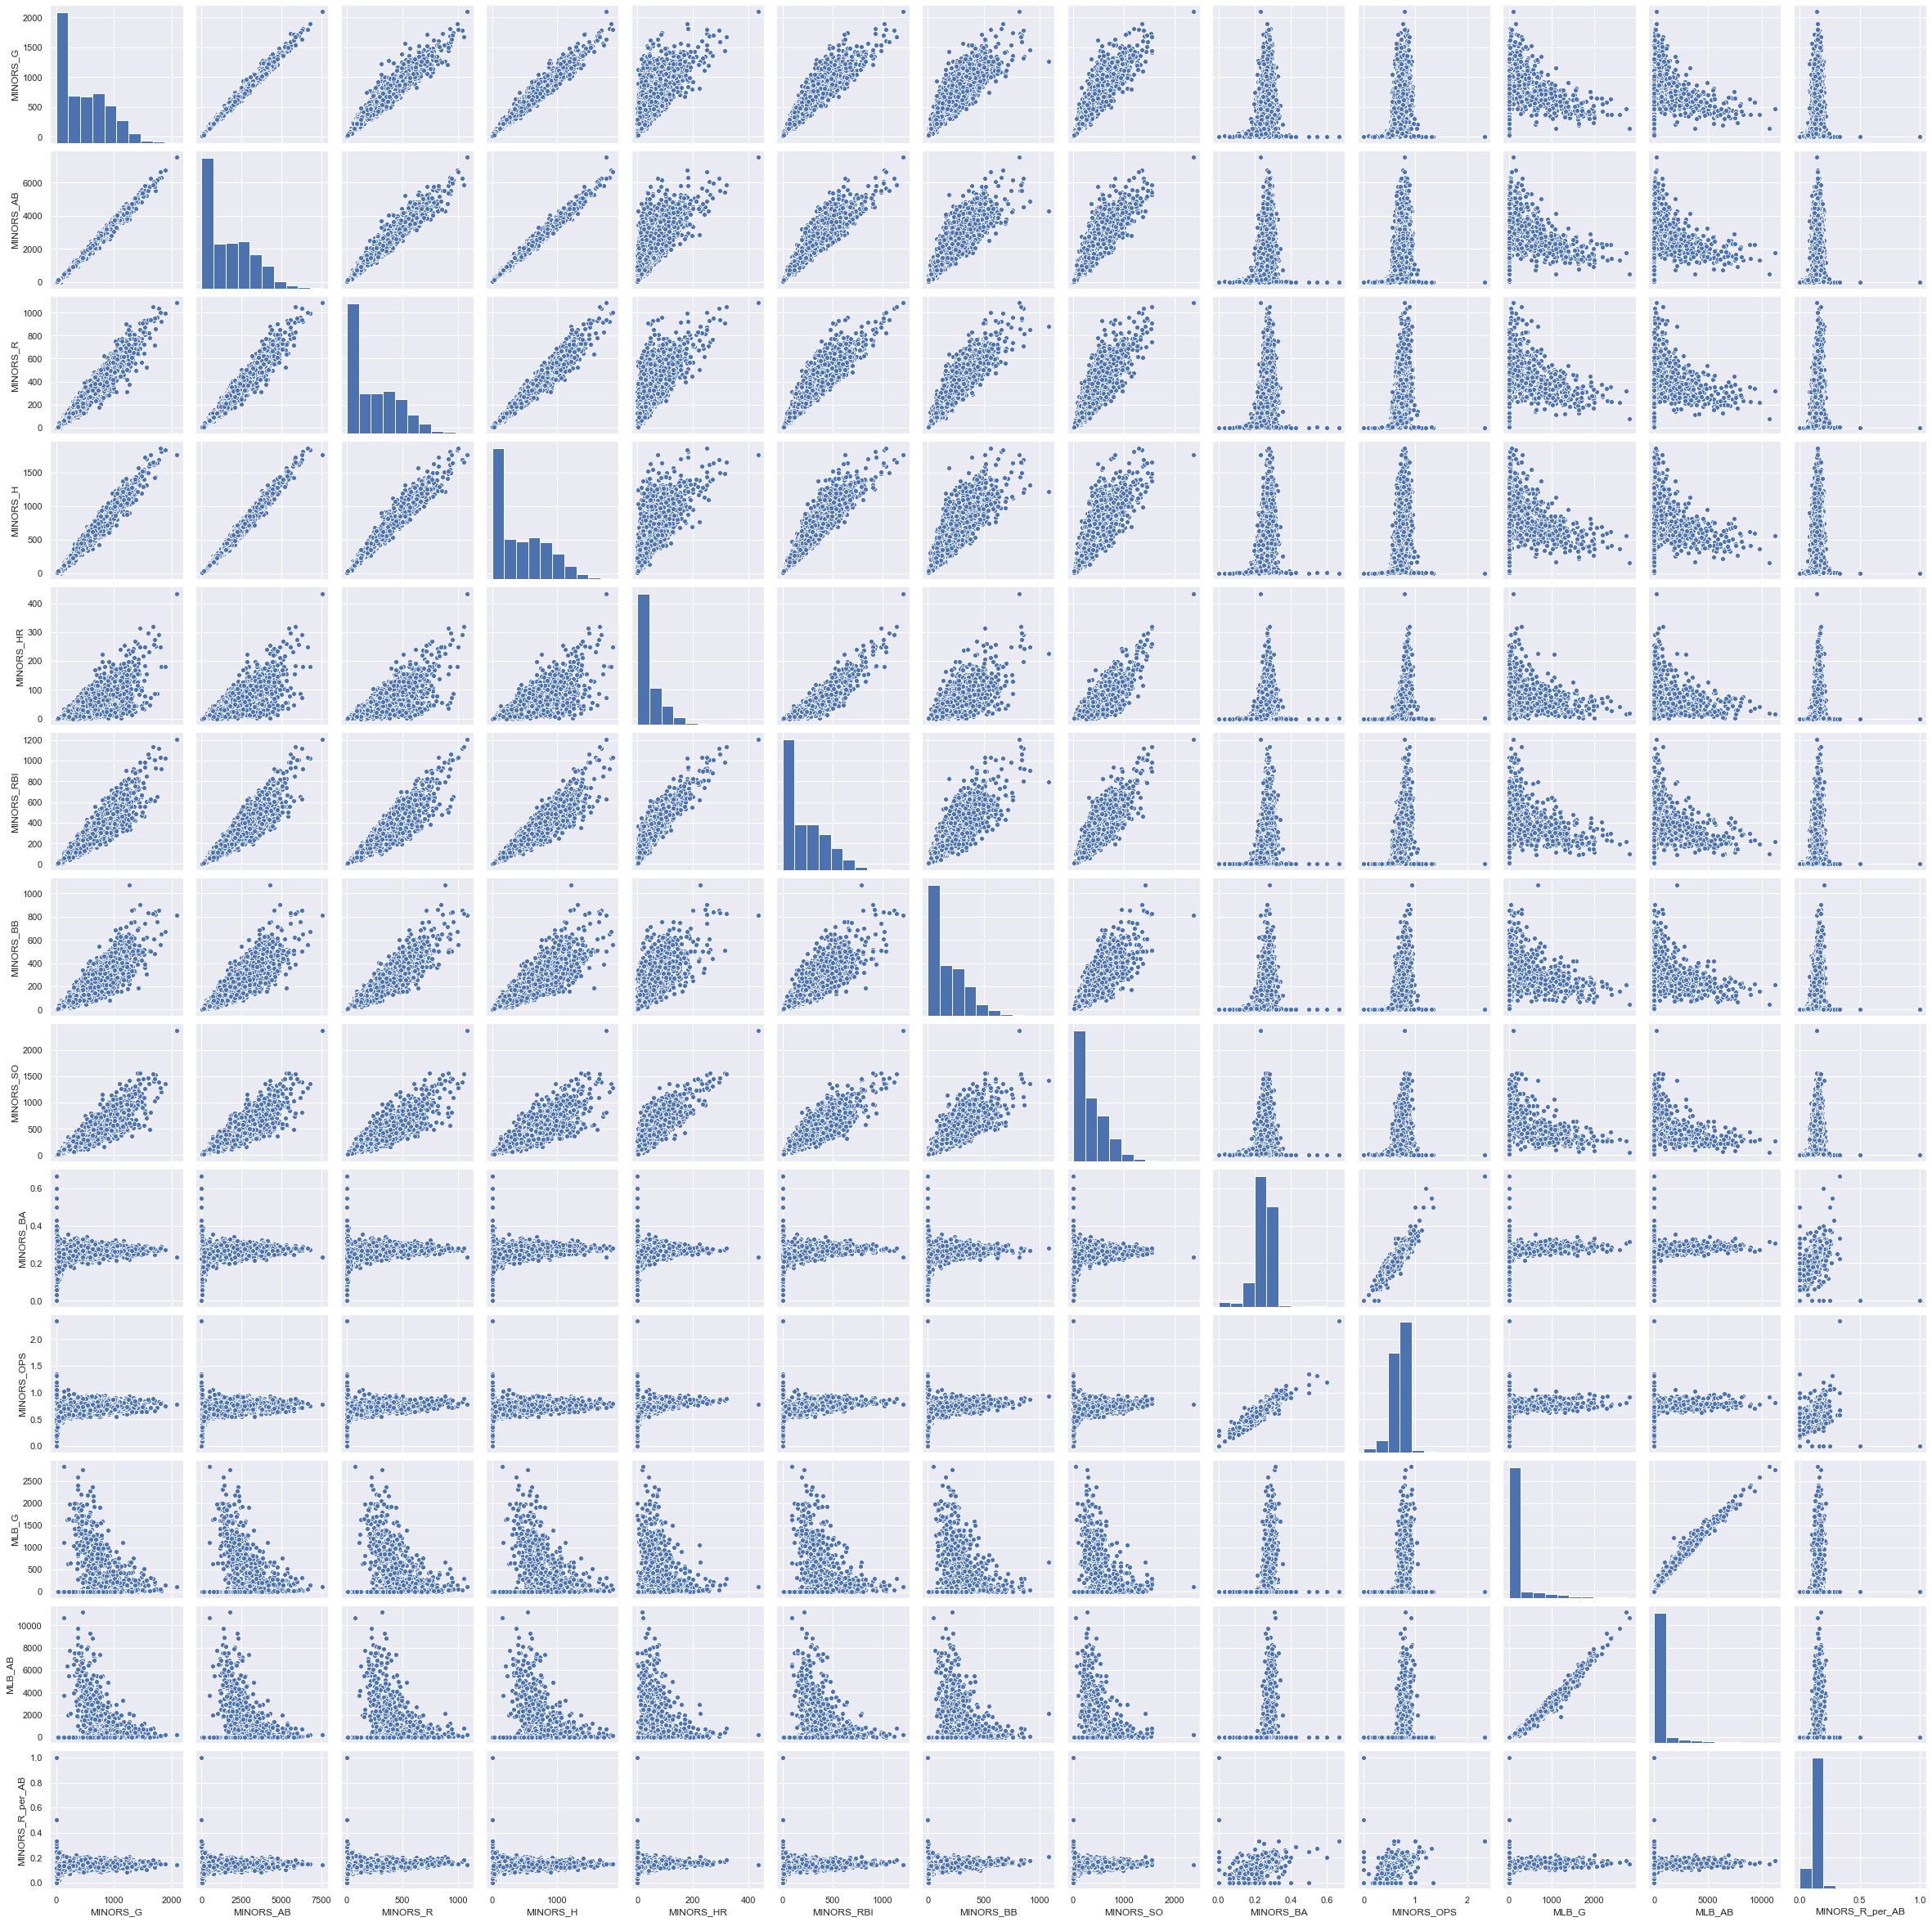

In [94]:
sns.pairplot(df2)

In [36]:
#created a df with only players who have played more than 50 minor league games. Trying to remove outliers
over_50_games = df2[df2['MINORS_G'] > 50]


In [284]:
with open('players_2000_over_50_G.pkl', 'wb') as handle:
    pickle.dump(over_50_games, handle, protocol=pickle.HIGHEST_PROTOCOL) 

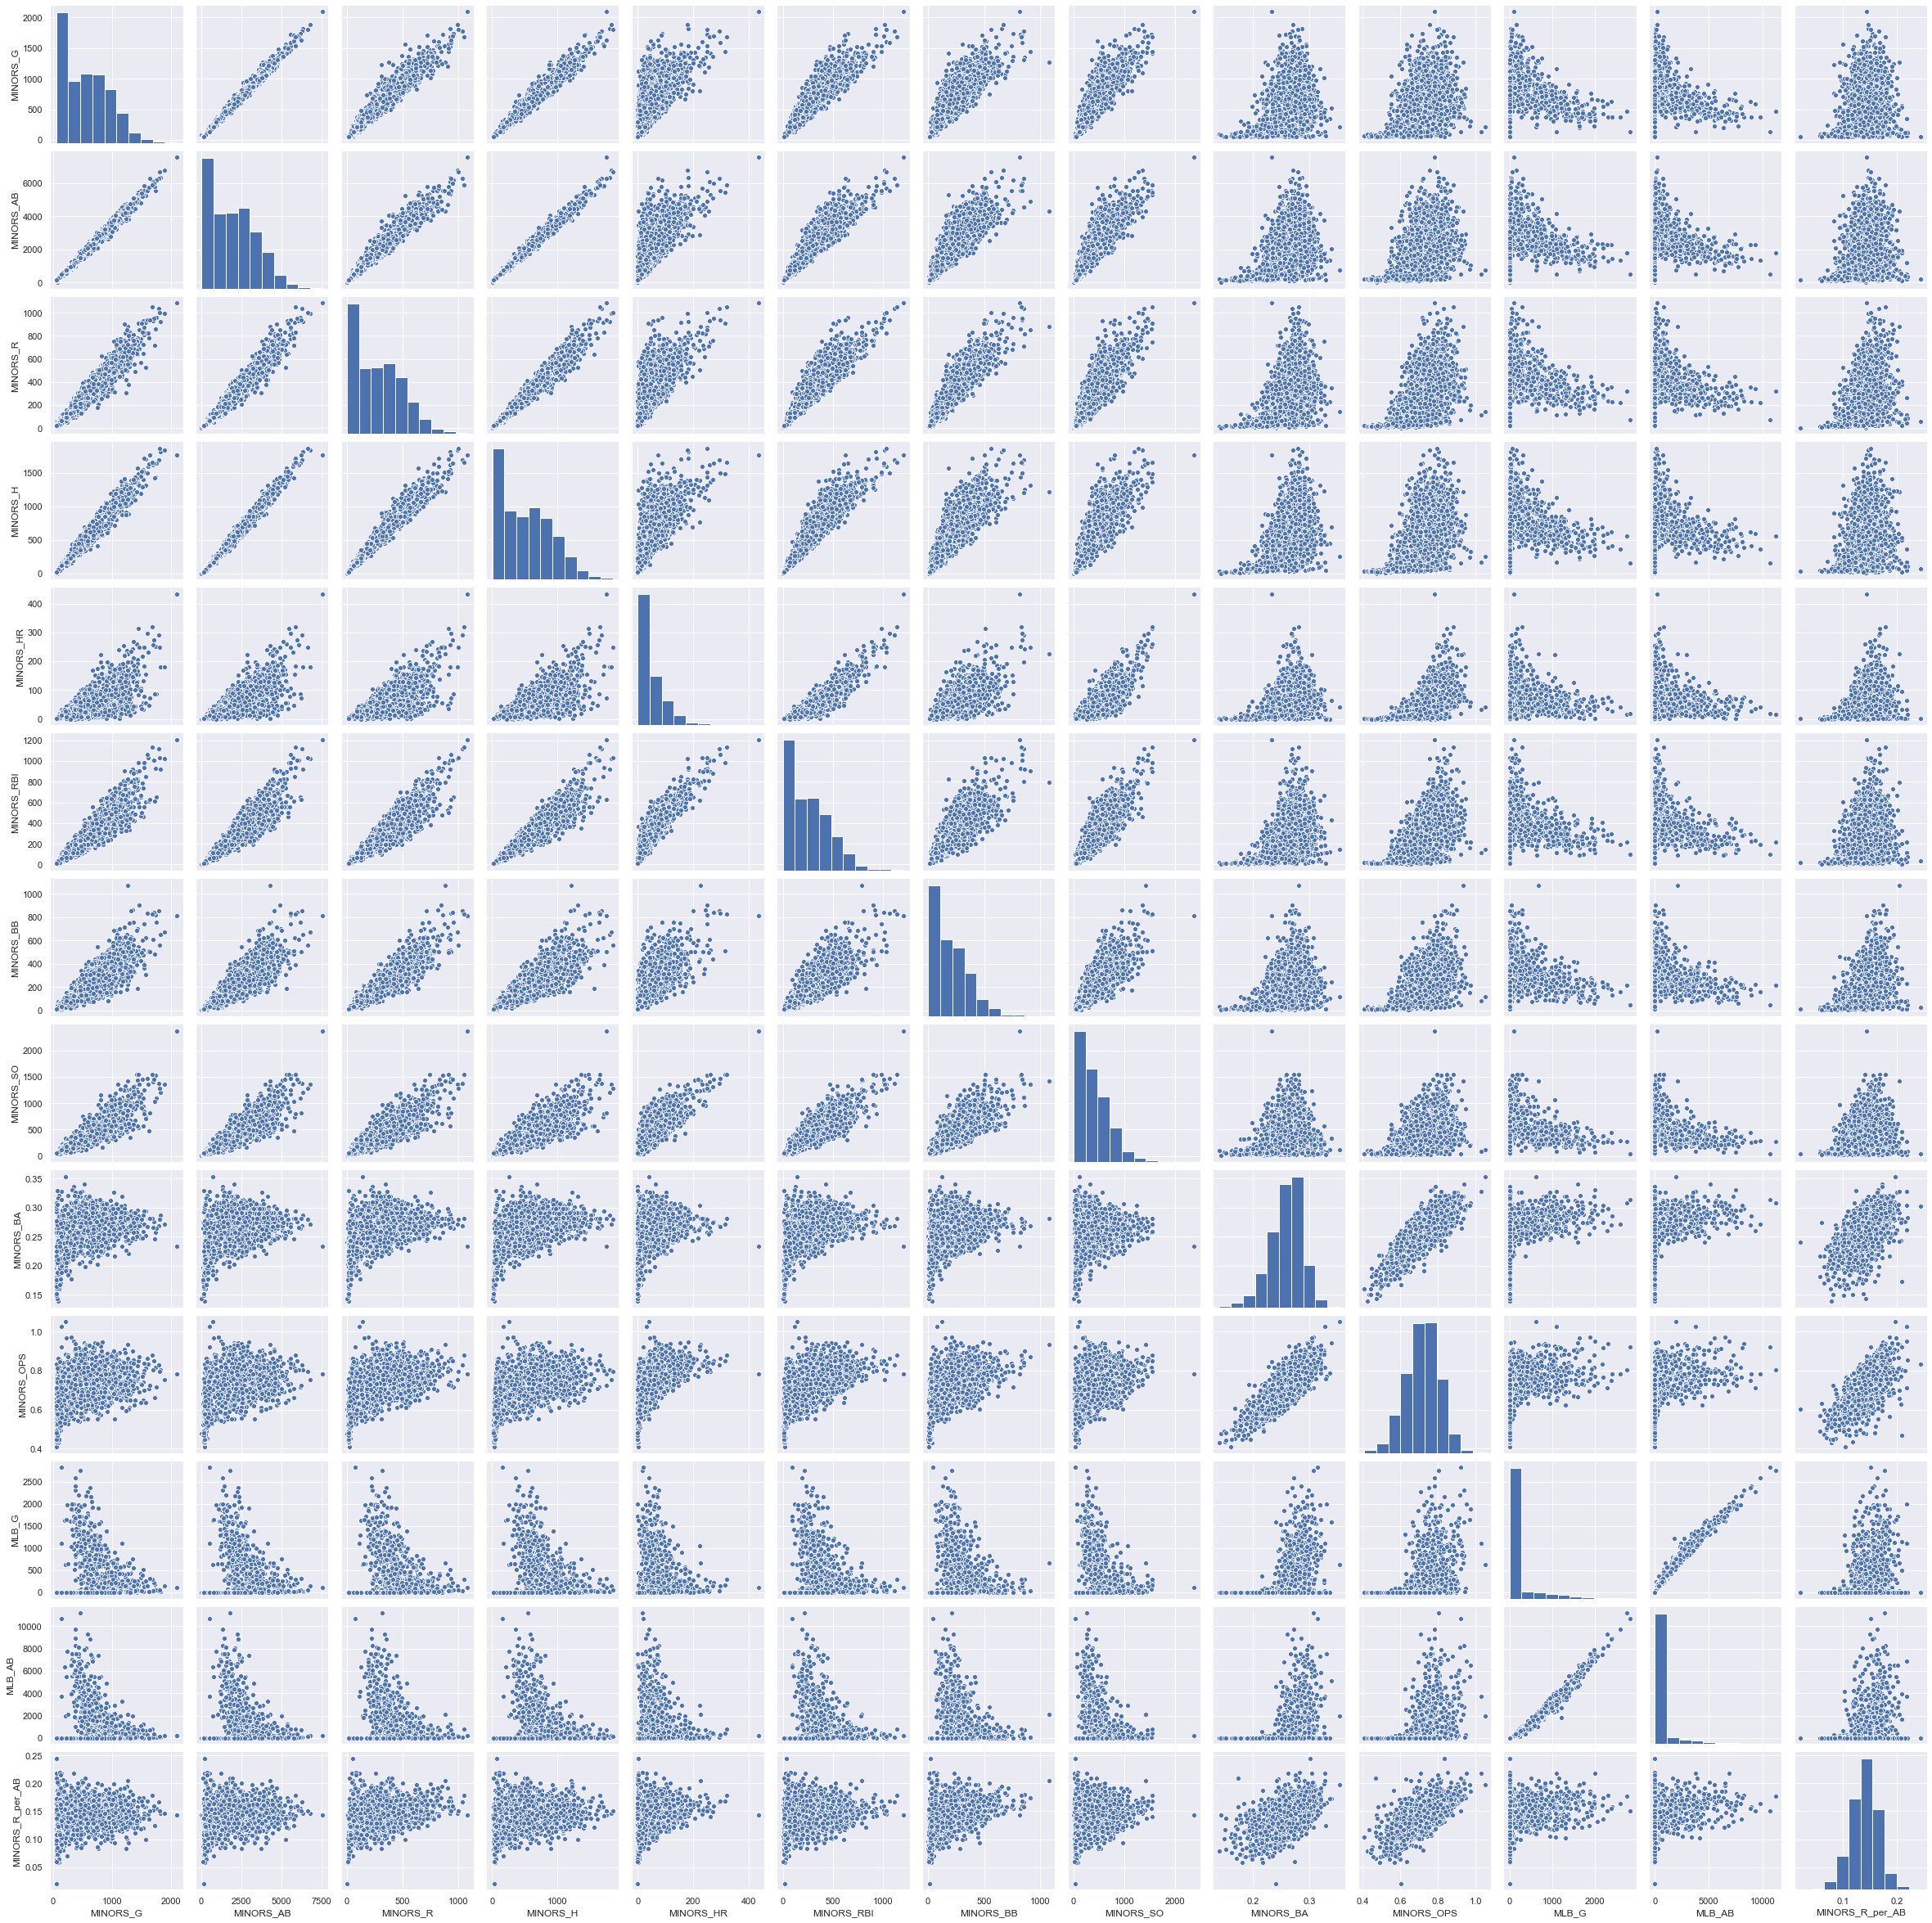

In [108]:
sns.pairplot(over_50_games)

# More Web Scraping

In [39]:
#making a list of team abbreviations to make web scraping easier
team_names = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'HOU', 'KCR', 'ANA', 'LAD', 'FLA', 'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'SEA', 'STL', 'TBD', 'TEX', 'TOR', 'MON']

In [37]:
#function to grab all hitters on MLB teams on 2000
def grab_MLB_2000_players():
    
    """
    Purpose: Grab every batter on an MLB roster in the year 2000
    Returns: a datafram with players and the url path to their stats page
    """
    
    player_list = []
    
    #looping through teams and grabbing the HTML for each team page
    for i in range(0,len(team_names)):
        url3 = 'https://www.baseball-reference.com/teams/' + team_names[i] + '/2000.shtml'
        response3 = requests.get(url3)
        page3 = response3.text
        soup3 = BeautifulSoup(page3, "lxml")

        name = ''
        major_league_url = ''
        minor_league_url = ''
        
        #grabbing the URL to each player's regular page, opening that page and grabbing the URL to their full stats
        #page
        for tag in soup3.find_all("tbody", limit=1):
            for i,tag2 in enumerate(tag.find_all('tr', limit=25)):
                for tag3 in tag2.find_all('td', attrs={"data-stat": "player"}):
                    name = tag3.find('a').text
                    major_league_url = tag3.find('a').get("href")

                    url4 = 'https://www.baseball-reference.com' + major_league_url
                    response4 = requests.get(url4)
                    page4 = response4.text
                    soup4 = BeautifulSoup(page4, "lxml")        
                    
                    #grabbing their name and correct url path here
                    for tag in soup4.find_all('div', limit=1, id='inner_nav'):
                        for i,tag2 in enumerate(tag.find_all('a', limit=2)):
                            if i == 1:
                                minor_league_url = tag2.get('href')
                                player_list.append([name,minor_league_url])
                                
    df = pd.DataFrame(player_list)
    return df
    

In [40]:
#running the above function
MLB_players_2000 = grab_MLB_2000_players()

In [41]:
#lets add all of our columns now and rename the ones we have:
MLB_players_2000['MINORS_G'] = 0
MLB_players_2000['MINORS_AB'] = 0
MLB_players_2000['MINORS_R'] = 0
MLB_players_2000['MINORS_H'] = 0
MLB_players_2000['MINORS_HR'] = 0
MLB_players_2000['MINORS_RBI'] = 0
MLB_players_2000['MINORS_BB'] = 0
MLB_players_2000['MINORS_SO'] = 0
MLB_players_2000['MINORS_BA'] = 0
MLB_players_2000['MINORS_OPS'] = 0
MLB_players_2000['MLB_G'] = 0
MLB_players_2000['MLB_AB'] = 0
MLB_players_2000 = MLB_players_2000.rename(columns={0:"player_name", 1:"url_path"})
empty_mlb_df = pd.DataFrame(MLB_players_2000)

In [42]:
MLB_players_2000.head(3)

player_name                               url_path  MINORS_G  MINORS_AB  \
0  Damian Miller  /register/player.fcgi?id=miller001dam         0          0   
1  Greg Colbrunn  /register/player.fcgi?id=colbru001gre         0          0   
2       Jay Bell  /register/player.fcgi?id=bell--001jay         0          0   

   MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  MINORS_BA  \
0         0         0          0           0          0          0          0   
1         0         0          0           0          0          0          0   
2         0         0          0           0          0          0          0   

   MINORS_OPS  MLB_G  MLB_AB  
0           0      0       0  
1           0      0       0  
2           0      0       0

In [44]:
#calling my previous webscraping function for my new major league player df
MLB_2000_player_stats = grab_player_stats(MLB_players_2000)

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/samir/opt/anaconda3/envs

In [45]:
MLB_2000_player_stats.head(3)

player_name                               url_path  MINORS_G  MINORS_AB  \
0  Damian Miller  /register/player.fcgi?id=miller001dam       696       2421   
1  Greg Colbrunn  /register/player.fcgi?id=colbru001gre       468       1680   
2       Jay Bell  /register/player.fcgi?id=bell--001jay       598       2112   

   MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO MINORS_BA  \
0       311       667         39         346        232        390      .276   
1       214       476         41         250        103        258      .283   
2       361       569         58         324        321        377      .269   

  MINORS_OPS  MLB_G  MLB_AB  
0       .731    989    3182  
1       .754    992    2769  
2       .791   2063    7398

In [46]:
#removing pitchers
MLB_2000_player_stats = MLB_2000_player_stats[MLB_2000_player_stats['MINORS_AB'] > 0]

In [47]:
#minor data cleaning
MLB_2000_player_stats.MINORS_OPS = pd.to_numeric(MLB_2000_player_stats.MINORS_OPS,downcast='float')

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
#minor data cleaning
MLB_2000_player_stats.MINORS_BA = pd.to_numeric(MLB_2000_player_stats.MINORS_BA,downcast='float')

In [50]:
#sns.pairplot(MLB_2000_player_stats)

In [51]:
#removing any remaining outliers
MLB_2000_player_stats = MLB_2000_player_stats[MLB_2000_player_stats['MINORS_G'] >  50]

In [285]:
with open('mlb_players_2000.pkl', 'wb') as handle:
    pickle.dump(MLB_2000_player_stats, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [287]:
with open('players_2000_over_50_G.pkl', 'rb') as handle:
    df2 = pickle.load(handle)

In [52]:
#feature engineering: I'm trying to make normalize all the stats by dividing by number of ABs each player had
MLB_2000_player_stats['MINORS_R_per_AB'] = MLB_2000_player_stats['MINORS_R']/MLB_2000_player_stats['MINORS_AB']

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
#ok now that the two dfs look the same I'm going to concat them together
mlb_and_minors = pd.concat([df2, MLB_2000_player_stats], ignore_index=True)
mlb_and_minors.head(3)

player_name                               url_path  MINORS_G  \
0  Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve       485   
1        Chuck Abbott  /register/player.fcgi?id=abbott002cha         9   
2        Larry Barnes  /register/player.fcgi?id=barnes002lar      1087   

   MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  \
0       1576       180       326         38         176        145        458   
1         24         1         3          0           4          2          9   
2       4018       627      1141        152         720        377        825   

   MINORS_BA  MINORS_OPS  MLB_G  MLB_AB  MINORS_R_per_AB  
0      0.207       0.622      0       0         0.114213  
1      0.125       0.359      0       0         0.041667  
2      0.284       0.833     46      78         0.156048

In [55]:
#drop duplicates in case any players were on a minor league team and a major league team in the year 2000
mlb_and_minors.drop_duplicates(['url_path'],inplace=True,ignore_index=True)

In [303]:
with open('total_players_2000.pkl', 'wb') as handle:
    pickle.dump(mlb_and_minors, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Basic EDA

In [56]:
y, X = patsy.dmatrices('MLB_AB ~ MINORS_R + MINORS_R_per_AB + MINORS_SO + MINORS_BA + MINORS_OPS', data=mlb_and_minors, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MLB_AB   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     104.3
Date:                Thu, 25 Jun 2020   Prob (F-statistic):          4.81e-101
Time:                        12:32:30   Log-Likelihood:                -24767.
No. Observations:                2775   AIC:                         4.955e+04
Df Residuals:                    2769   BIC:                         4.958e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2072.7861    190.290    -10.893      0.000   -2445.911   -1699.661
MINORS_R            4.0173      0.420      9.560      0.000       3.193       4.841
MINORS_R_per_AB  3038.7413   1014.362      2.996      0.003    1049.759    5027.724
MINORS_SO          -3.5366      0.297    -11.925      0.000      -4.118      -2.955
MINORS_BA       -3531.6989   1742.730     -2.027      0.043   -6948.881    -114.517
MINORS_OPS       5232.3682    654.564      7.994      0.000    3948.885    6515.851
==============================================================================
Omnibus:                     1197.201   Durbin-Watson:                   1.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5296.617
Skew:                           2.099   Prob(JB):                         0.00
Kurtosis:                       8.309   Cond. No.                     2.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
#a little bit more featur engineering. Like I said before, we need to normalize these stats because these players
# all played for a different amount of years

mlb_and_minors['MINORS_SO_per_AB'] = mlb_and_minors['MINORS_SO']/mlb_and_minors['MINORS_AB']
mlb_and_minors['MINORS_BB_per_AB'] = mlb_and_minors['MINORS_BB']/mlb_and_minors['MINORS_AB']

In [58]:
mlb_and_minors.head(3)

player_name                               url_path  MINORS_G  \
0  Evert-Jean 't Hoen  /register/player.fcgi?id=thoen-001eve       485   
1        Chuck Abbott  /register/player.fcgi?id=abbott002cha         9   
2        Larry Barnes  /register/player.fcgi?id=barnes002lar      1087   

   MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  MINORS_RBI  MINORS_BB  MINORS_SO  \
0       1576       180       326         38         176        145        458   
1         24         1         3          0           4          2          9   
2       4018       627      1141        152         720        377        825   

   MINORS_BA  MINORS_OPS  MLB_G  MLB_AB  MINORS_R_per_AB  MINORS_SO_per_AB  \
0      0.207       0.622      0       0         0.114213          0.290609   
1      0.125       0.359      0       0         0.041667          0.375000   
2      0.284       0.833     46      78         0.156048          0.205326   

   MINORS_BB_per_AB  
0          0.092005  
1          0.083333  
2          0.093828

In [59]:
y, X = patsy.dmatrices('MLB_AB ~ MINORS_R_per_AB + MINORS_BB_per_AB + MINORS_SO_per_AB + MINORS_BA + MINORS_OPS', data=mlb_and_minors, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MLB_AB   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     84.54
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           7.07e-83
Time:                        12:32:56   Log-Likelihood:                -24809.
No. Observations:                2775   AIC:                         4.963e+04
Df Residuals:                    2769   BIC:                         4.967e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -948.2833    275.670     -3.440      0.001   -1488.822    -407.744
MINORS_R_per_AB   4903.6217   1021.291      4.801      0.000    2901.052    6906.191
MINORS_BB_per_AB  1353.7462    972.667      1.392      0.164    -553.479    3260.971
MINORS_SO_per_AB -3727.5089    489.859     -7.609      0.000   -4688.034   -2766.984
MINORS_BA        -2334.0960   2099.941     -1.112      0.266   -6451.704    1783.512
MINORS_OPS        3522.5464    742.460      4.744      0.000    2066.715    4978.378
==============================================================================
Omnibus:                     1253.205   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5563.153
Skew:                           2.219   Prob(JB):                         0.00
Kurtosis:                       8.331   Cond. No.                         82.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [351]:
with open('total_players_2000.pkl', 'wb') as handle:
    pickle.dump(mlb_and_minors, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
mlb_and_minors.corr()

MINORS_G  MINORS_AB  MINORS_R  MINORS_H  MINORS_HR  \
MINORS_G          1.000000   0.996136  0.971008  0.986135   0.779283   
MINORS_AB         0.996136   1.000000  0.979187  0.994462   0.783435   
MINORS_R          0.971008   0.979187  1.000000  0.983716   0.803038   
MINORS_H          0.986135   0.994462  0.983716  1.000000   0.782832   
MINORS_HR         0.779283   0.783435  0.803038  0.782832   1.000000   
MINORS_RBI        0.941945   0.946860  0.943343  0.951135   0.919336   
MINORS_BB         0.903369   0.895397  0.931419  0.892946   0.769238   
MINORS_SO         0.917425   0.913277  0.903415  0.888355   0.857750   
MINORS_BA         0.406693   0.420400  0.444090  0.452972   0.329327   
MINORS_OPS        0.434827   0.443654  0.489091  0.470495   0.496870   
MLB_G             0.104560   0.125576  0.166159  0.155024   0.122364   
MLB_AB            0.067142   0.088034  0.127755  0.116865   0.095804   
MINORS_R_per_AB   0.266392   0.275942  0.355393  0.296359   0.272048   
MINORS_SO_per_AB -0.258707  -0.269160 -0.257898 -0.294827  -0.048178   
MINORS_BB_per_AB  0.096020   0.080169  0.153105  0.084274   0.139688   

                  MINORS_RBI  MINORS_BB  MINORS_SO  MINORS_BA  MINORS_OPS  \
MINORS_G            0.941945   0.903369   0.917425   0.406693    0.434827   
MINORS_AB           0.946860   0.895397   0.913277   0.420400    0.443654   
MINORS_R            0.943343   0.931419   0.903415   0.444090    0.489091   
MINORS_H            0.951135   0.892946   0.888355   0.452972    0.470495   
MINORS_HR           0.919336   0.769238   0.857750   0.329327    0.496870   
MINORS_RBI          1.000000   0.883254   0.909145   0.428290    0.514775   
MINORS_BB           0.883254   1.000000   0.861571   0.392079    0.484308   
MINORS_SO           0.909145   0.861571   1.000000   0.321375    0.419119   
MINORS_BA           0.428290   0.392079   0.321375   1.000000    0.910024   
MINORS_OPS          0.514775   0.484308   0.419119   0.910024    1.000000   
MLB_G               0.153362   0.155015   0.043093   0.324661    0.340351   
MLB_AB              0.118411   0.116526   0.014197   0.309032    0.324082   
MINORS_R_per_AB     0.293588   0.355587   0.259920   0.485664    0.554624   
MINORS_SO_per_AB   -0.210656  -0.197433  -0.036008  -0.501928   -0.341012   
MINORS_BB_per_AB    0.120278   0.348585   0.124931   0.141281    0.346931   

                     MLB_G    MLB_AB  MINORS_R_per_AB  MINORS_SO_per_AB  \
MINORS_G          0.104560  0.067142         0.266392         -0.258707   
MINORS_AB         0.125576  0.088034         0.275942         -0.269160   
MINORS_R          0.166159  0.127755         0.355393         -0.257898   
MINORS_H          0.155024  0.116865         0.296359         -0.294827   
MINORS_HR         0.122364  0.095804         0.272048         -0.048178   
MINORS_RBI        0.153362  0.118411         0.293588         -0.210656   
MINORS_BB         0.155015  0.116526         0.355587         -0.197433   
MINORS_SO         0.043093  0.014197         0.259920         -0.036008   
MINORS_BA         0.324661  0.309032         0.485664         -0.501928   
MINORS_OPS        0.340351  0.324082         0.554624         -0.341012   
MLB_G             1.000000  0.991012         0.259843         -0.249573   
MLB_AB            0.991012  1.000000         0.248507         -0.234348   
MINORS_R_per_AB   0.259843  0.248507         1.000000         -0.138592   
MINORS_SO_per_AB -0.249573 -0.234348        -0.138592          1.000000   
MINORS_BB_per_AB  0.145154  0.134458         0.316487          0.041319   

                  MINORS_BB_per_AB  
MINORS_G                  0.096020  
MINORS_AB                 0.080169  
MINORS_R                  0.153105  
MINORS_H                  0.084274  
MINORS_HR                 0.139688  
MINORS_RBI                0.120278  
MINORS_BB                 0.348585  
MINORS_SO                 0.124931  
MINORS_BA                 0.141281  
MINORS_OPS                0.346931  
MLB_G                   

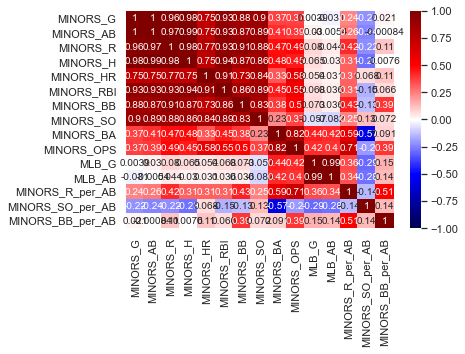

In [317]:
sns.heatmap(mlb_and_minors.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

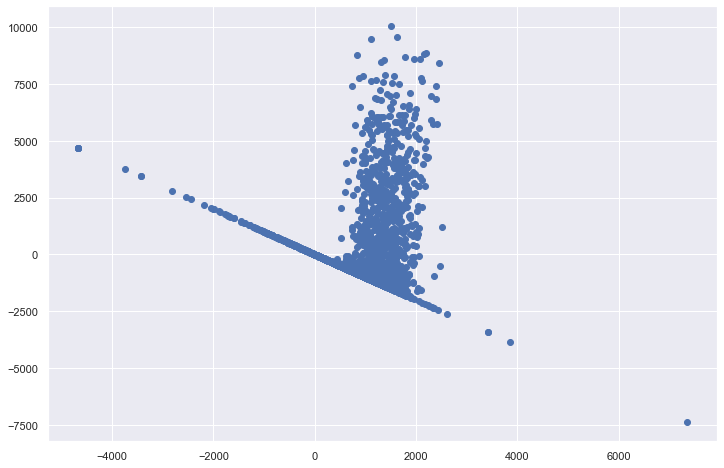

In [61]:
#plotting residuals
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

This residual plot shows heteroskedacicity. I think this is happening because most players don't have a very long MLB career and then there are the few all-stars that have long careers.

In [321]:
fit.save('first_regression_model.pkl')